# Predicting survivals in the Titanic disaster 
In this notebook I am going to employ machine learning techniques to predict who survived in the Titanic disaster based on data in the Kaggle website (https://www.kaggle.com/c/titanic). More details can be found in the link above.

After importing the relevant packages I will prepare the data such that it can be fed to learning algorithms. 

In [1]:
import sys
import numpy as np
import numpy.random as npr
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import *

%matplotlib inline

### Data preparation

In [2]:
# Prepare the date such that it can be used by learning algorithms. Most of it consists in
# replacing strings by numbers. 
def prepare_data(data):
    # Add two new features: Title and Family.
    new_columns = ['Title', 'Family']
    df = pd.DataFrame(np.zeros((data.shape[0], 2)), columns=new_columns)
    data = pd.concat([data, df], axis=1)
    
    # Set null values to -1.
    data = data.fillna(-1)
    
    
    # Define the set of names.
    name_set = set()
    
    for i in data.index:
        # Get family name.
        name_split = data.loc[i, 'Name'].split(',')
        name = name_split[0]

        if name not in name_set:
            name_set.add(name)
        elif data.loc[i, 'Parch'] == 0 and data.loc[i, 'SibSp'] == 0:
            while name in name_set:
                name = name + '0'

            name_set.add(name)

        data.loc[i, 'Name'] = name
        
        # Get title. 
        # The title is restricted to be 'Mister.', 'Ms.', 'Master.', and 'Miss.'.
        name_split = name_split[1].split()
        title = name_split[0]
        
        if title != 'Master.' and data.loc[i, 'Sex'] == 'male':
            title = 'Mr.'
        elif title == 'Mlle.':
            title = 'Miss.'
        elif title != 'Miss.' and data.loc[i, 'Sex'] == 'female':
            title = 'Ms.'
        
        data.loc[i, 'Title'] = title
        
        # The 'Family' feature is 1 if Parch > 0 and SibSp > 0 and zero otherwise.
        if (data.loc[i, 'Parch'] > 0) and (data.loc[i, 'SibSp'] > 0):
            data.loc[i, 'Family'] = 1

    # Define dictionaries to convert string data to integers.
    name_dict = {name: i for i, name in enumerate(name_set)}
    title_dict = {'Miss.': 0, 'Master.': 1, 'Ms.': 2, 'Mr.': 3}
    sex_dict = {'female': 0, 'male': 1}
    
    ticket_set = set(data.loc[:, 'Ticket'])
    if -1 in ticket_set:
        ticket_set.remove(-1)
    ticket_dict = {ticket: i for i, ticket in enumerate(ticket_set)}
    
    cabin_set = set(data.loc[:, 'Cabin'])
    if -1 in cabin_set:
        cabin_set.remove(-1)
    cabin_dict = {cabin: i for i, cabin in enumerate(cabin_set)}
    
    port_dict = {'C': 0, 'Q': 1, 'S': 2}
    
    # Parameter tranformation.
    for i in data.index:
        # Name to int.
        name = data.loc[i, 'Name']
        data.loc[i, 'Name'] = name_dict[name] 
        # Title to int.
        data.loc[i, 'Title'] = title_dict[data.loc[i, 'Title']]
        # Sex to int.
        data.loc[i, 'Sex'] = sex_dict.get(data.loc[i, 'Sex'], -1)
        # Embarked to int.
        data.loc[i, 'Embarked'] = port_dict.get(data.loc[i, 'Embarked'], -1)
        # Ticket to int.
        data.loc[i, 'Ticket'] = ticket_dict.get(data.loc[i, 'Ticket'], -1)
        # Cabin to int.
        data.loc[i, 'Cabin'] = cabin_dict.get(data.loc[i, 'Cabin'], -1)
    
    # Set data type to float32.
    data = data.astype('float32')
    return data

def fill_nulls(data):
    # Here we try to make some reasonable assumptions for the null values.
    # Remember that those values were replaced by -1.
    
    # If SibSp is null, set SibSp to zero.
    mask = (data.loc[:, 'SibSp'] == -1)
    data.loc[mask, 'SibSp'] = 0

    # If Parch is null, set Parch to zero.
    mask = (data.loc[:, 'Parch'] == -1)
    data.loc[mask, 'Parch'] = 0

    # Null valuesfor the Fare are estimated as the average fare in each class.
    for c in [1, 2, 3]:
        mask = (data.loc[:, 'Pclass'] == c) & (data.loc[:, 'Fare'] > -1)
        fares = data.loc[mask, 'Fare'].values
        mean_fare = np.mean(fares)
        mask = (data.loc[:, 'Pclass'] == c) & (data.loc[:, 'Fare'] == -1)
        data.loc[mask, 'Fare'] = mean_fare

    # Mask of the non-null ages.
    ages = (data.loc[:, 'Age'] > -1)

    # Null values for the Age are estimated using different strategies.
    # If the passenger is a 'Master.', we use the average age in this group.
    masters = (data.loc[:, 'Title'] == 1)
    mean_age = np.mean(data.loc[masters & ages, 'Age'].values)
    data.loc[masters & ~ages, 'Age'] = mean_age

    # If the passenger is a 'Miss.' and has Parch > 0, we use the average age
    # in this group.
    misses = (data.loc[:, 'Title'] == 0)
    has_Parch = (data.loc[:, 'Parch'] > 0)
    mean_age = np.mean(data.loc[misses & has_Parch & ages, 'Age'].values)
    data.loc[misses & has_Parch & (~ages), 'Age'] = mean_age

    # If the passenger is a 'Miss.' and has Parch = 0, we use the average age
    # in this group.
    mean_age = np.mean(data.loc[misses & (~has_Parch) & ages, 'Age'].values)
    data.loc[misses & (~has_Parch) & (~ages), 'Age'] = mean_age

    # If the passenger is a 'Mister.' or a 'Ms.' we use the average age for each 
    # title in each class group.
    for c in [1, 2, 3]:
        class_c = (data.loc[:, 'Pclass'] == c)
        for title in [2, 3]:# Corresponds to ['Mr.', 'Ms.'].
            mask_title = (data.loc[:, 'Title'] == title)#(data.loc[:, 'Title'] == title_dict[title])
            mask = ages & class_c & mask_title
            mean_age = np.mean(data.loc[mask, 'Age'].values)
            mask = ~ages & class_c & mask_title
            data.loc[mask, 'Age'] = mean_age
            
    return data

In [3]:
from sklearn import model_selection

# Read training data.
data = pd.read_csv('train.csv')
input_train, labels_train = data.iloc[:, 2: ].copy(), data.iloc[:, 1].copy()

# Read final test data. Predictions using this data are used by 
# Kaggle to measure the performance of your algorithm.
input_test = pd.read_csv('test.csv')
input_test = input_test.set_index(np.arange(input_test.shape[0]) + input_train.shape[0])

# Prepare both training and test data.
full_input = pd.concat([input_train, input_test.iloc[:, 1: ]].copy(), axis=0)
full_input = prepare_data(full_input)
full_input = fill_nulls(full_input)

# Select features that I deemed relevant for the classification task.
input_fields = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title', 
                'Family']
full_input = full_input.loc[:, input_fields]
input_train = full_input.loc[labels_train.index, :]
input_test = full_input.loc[input_test.index, :]

# Create numpy arrays.
X = input_train.values
y = labels_train.values

# Shuffle and devide sets.
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size=0.1)

## Tree
We first attempt to solve this task using trees. In order to avoid very alrge trees that are doomed to overfit we employ pruning.
### Single Tree with pruning

In [4]:
import bisect
from sklearn import tree

# In order to find the ideal pruning coefficient, I am going to use cross-validation.
divisions = 7
accuracy_array = np.zeros((10**4, divisions, 2))

for j in range(divisions):
    # Select cross-validation set 
    shift = Xtrain.shape[0]//divisions
    Xvalidation = Xtrain[0: shift, :]
    yvalidation = ytrain[0: shift]
    Xtrain_j = Xtrain[shift: , :]
    ytrain_j = ytrain[shift: ]
    
    # build tree and prune it
    clf = tree.DecisionTreeClassifier(max_depth=10, 
                                      min_samples_leaf=5,
                                      random_state=0)
    path = clf.cost_complexity_pruning_path(Xtrain_j, ytrain_j)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    # create a list of pruned trees
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha,
                                          random_state=0)
        clf.fit(Xtrain_j, ytrain_j)
        clfs.append(clf)
        
    # create list with relevant values for the pruning constant alpha
    if j == 0:
        alpha_array = np.linspace(ccp_alphas[0], ccp_alphas[-1], accuracy_array.shape[0])
        
    # calculate score in the training and validation sets for all pruned trees
    train_scores = [clf.score(Xtrain_j, ytrain_j) for clf in clfs]
    validation_scores = [clf.score(Xvalidation, yvalidation) for clf in clfs]
    
    # the scores are saved in accuracy list in accordance with the value of alpha
    for i, alpha in enumerate(alpha_array):
        index = bisect.bisect_left(ccp_alphas, alpha)
        if index == 0:
            index = 1
        accuracy_array[i, j, 0] = train_scores[index - 1]
        accuracy_array[i, j, 1] = validation_scores[index - 1]

    Xtrain = np.roll(Xtrain, shift, axis=0)
    ytrain = np.roll(ytrain, shift)

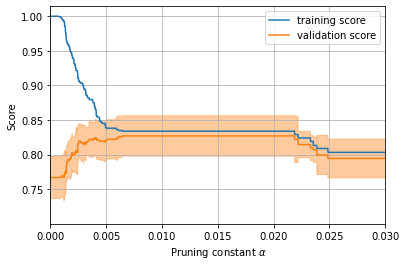

In [5]:
# plot the average training and validation score
fig, ax = plt.subplots()

acc_mean = np.mean(accuracy_array[:, :, 0], axis=1)
ax.plot(alpha_array, acc_mean, label='training score')

acc_mean = np.mean(accuracy_array[:, :, 1], axis=1)
acc_std = np.std(accuracy_array[:, :, 1], axis=1)
ax.plot(alpha_array, acc_mean, label='validation score')
ax.fill_between(alpha_array, acc_mean - acc_std, acc_mean + acc_std, color='C1', alpha=0.4)

ax.set_ylabel('Score')
ax.set_xlabel(r'Pruning constant $\alpha$')
ax.set_xlim(0, 0.03)
ax.legend()
ax.grid()

As the pruning constant alpha increases the overfitting deceases, as one would expect. Note however that the curves represent the average score computed using cross-validation. In order to have estimative of the fluctuation in the validation score we filled the region within one standard deviation of distance from the average validation score. As we can see,  the fluctuations are very substantial. This confirms a well known fact: trees are unstable. Small changes in the training data can lead to very different classifiers with very different performances.

In the following we are going to select a value of alpha that performs well, build a tree with the complete training set, and test the tree on the test set. Here I do not see a reason for being very careful with the choice of alpha since we have seen that trees are unstable. Possibly values between 0.005 and 0.01 will perform equally well.  

score: 0.822
tree depth: 3
number of leaves: 5


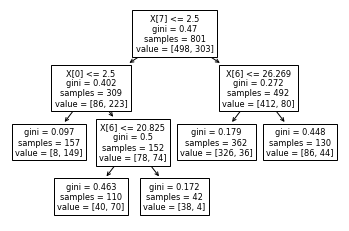

In [6]:
# tree with a specific alpha
clf = tree.DecisionTreeClassifier(ccp_alpha=0.009)
clf.fit(Xtrain, ytrain)
print('score: %.3f' % clf.score(Xtest, ytest))
print('tree depth: %d' % clf.tree_.max_depth)
print('number of leaves: %d' % clf.tree_.n_leaves)
tree_img = tree.plot_tree(clf)

In [7]:
# save a representation of the tree in pdf
import graphviz

dot_data = tree.export_graphviz(clf, feature_names=input_fields, class_names=['0', '1'], 
                                out_file=None)
graph = graphviz.Source(dot_data) 
graph.render("titanic_tree") 

'titanic_tree.pdf'

## Bagging
In order to tacle the problem of instability of trees, I am going to the Bagging ensemble technique. This technique consists of using bootstrap samples to train a large number of trees. In this case, the class for a specific set of features is given by majority vote. An interesting feature of the Bagging ensemble is the fact that one can use out-of-bag samples to estimate the error of the classifier and therefore avoid overfitting. 

In [8]:
from sklearn import ensemble

for sample_share in np.linspace(0.2, 0.5, 7):   
    class_tree = tree.DecisionTreeClassifier(max_depth=8)
    clf = ensemble.BaggingClassifier(class_tree, 
                                     n_estimators=3000, 
                                     max_samples=sample_share, 
                                     oob_score=True)
    clf.fit(Xtrain, ytrain)      
    print("sample share: %.2f, score: %.3f" % (sample_share, clf.oob_score_))

sample share: 0.20, score: 0.833
sample share: 0.25, score: 0.835
sample share: 0.30, score: 0.838
sample share: 0.35, score: 0.836
sample share: 0.40, score: 0.836
sample share: 0.45, score: 0.836
sample share: 0.50, score: 0.833


Note that the pruned tree had a depth of 3 while the elements of the Bagging ensemble have a depth of 8. When working with a Bagging ensemble one tries to minimize variance with the use of an ensemble. A very constrained tree, such as the pruned tree considered in the last subsection, is not expected to perform well in this case, since the variance is relatively small and the bias is relatively large. Probably the use of a bagging ensemble will not be very advantageous. However, if we allow high variance trees with low bias, we can achieve good results. Indeed the best results I obtained were obtained with bagged trees with depth 8 . 

In [9]:
class_tree = tree.DecisionTreeClassifier(max_depth=8)
clf = ensemble.BaggingClassifier(class_tree, n_estimators=3000, max_samples=0.35, oob_score=True)
clf.fit(Xtrain, ytrain)
print('Score in the test set: %.3f' % clf.score(Xtest, ytest))

Score in the test set: 0.844


## Gradient boosting
Here we are going to apply Gradient boosting to the classification task. We are going to use cross-validation to see how unstable this method is.

In [10]:
acc_array = np.zeros((2, 100))

for i in range(acc_array.shape[1]):
    # shuffle rows
    permutation = np.random.permutation(np.arange(X.shape[0]))
    X = X[permutation, :]
    y = y[permutation]
    
    Xval = X[-80: , :]
    yval = y[-80: ]
    Xtrain = X[0: -80, :]
    ytrain = y[0: -80]

    clf = ensemble.GradientBoostingClassifier(n_estimators=100, 
                                              max_depth=3,
                                              learning_rate=0.05)  
    clf.fit(Xtrain, ytrain)
    
    acc_array[0, i] = clf.score(Xtrain, ytrain)
    acc_array[1, i] = clf.score(Xval, yval)
    
print('Training score: %.3f +/- %.3f' % (np.mean(acc_array[0, :]), np.std(acc_array[0, :])))
print('Validation score: %.3f +/- %.3f' % (np.mean(acc_array[1, :]), np.std(acc_array[1, :])))

Training score: 0.875 +/- 0.005
Validation score: 0.828 +/- 0.039


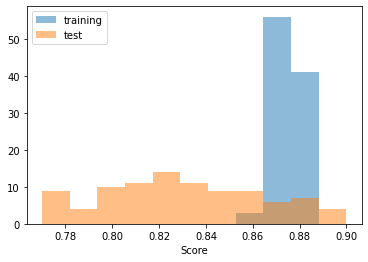

In [11]:
fig, ax = plt.subplots()
bins = np.linspace(0.77, 0.9, 12)
ax.hist(acc_array[0, :], bins=bins, label='training', alpha=0.5)
ax.hist(acc_array[1, :], bins=bins, label='test', alpha=0.5, color='C1')
ax.set_xlabel('Score')
ax.legend()

The figure above shows that some estimator ensembles did not perform well on the validation set. On the other hand, the estimator ensemble performed relatively well on the training set. We can draw two conclusion here:
- The classifier is unstable. We conclude that from the fact that classifiers trained using different data have very different performance.
- The classifier is overfitting. We conclude that from the fact that the training score is usually larger than the validation score.

In the following we try to correct these problems by using early stop and shallow trees.

In [12]:
acc_array = np.zeros((2, 100))
# We are going to fit 10 ensembles, choosing different validation sets, to make sure that our 
# results are reliable.
for i in range(acc_array.shape[1]):
    # shuffle rows
    permutation = np.random.permutation(np.arange(X.shape[0]))
    X = X[permutation, :]
    y = y[permutation]
    
    Xval = X[-80: , :]
    yval = y[-80: ]
    Xtrain = X[0: -80, :]
    ytrain = y[0: -80]

    # We set 10% of X aside to be our 'second' validation set. If after 5 iterations there is no 
    # improvement in the validation score we stop the fitting.
    clf = ensemble.GradientBoostingClassifier(n_estimators=50, 
                                              validation_fraction=0.1, 
                                              learning_rate=0.05, 
                                              n_iter_no_change=5, 
                                              tol=2e-3, 
                                              max_leaf_nodes=3)
    clf.fit(Xtrain, ytrain)
    
    acc_array[0, i] = clf.score(Xtrain, ytrain)
    acc_array[1, i] = clf.score(Xval, yval)
    
print('Training score: %.3f +/- %.3f' % (np.mean(acc_array[0, :]), np.std(acc_array[0, :])))
print('Validation score: %.3f +/- %.3f' % (np.mean(acc_array[1, :]), np.std(acc_array[1, :])))

Training score: 0.827 +/- 0.005
Validation score: 0.819 +/- 0.042


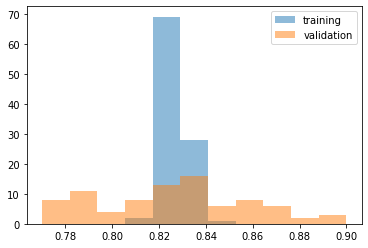

In [13]:
fig, ax = plt.subplots()
bins = np.linspace(0.77, 0.9, 12)
ax.hist(acc_array[0, :], bins=bins, label='training', alpha=0.5)
ax.hist(acc_array[1, :], bins=bins, label='validation', alpha=0.5, color='C1')
ax.legend()

The figure above shows that our attempt to reduce the overfitting was not successful. We did manage to bring the training score and the validation score closer to each other, however the classifier is still unstable. This can be seen in the figure by the fact that the orange histogram is much wider than the blue histogram. The instability of the classifier is a problem that still needs to be tackled.

### Random Forests
Now we are going to apply the random forest classifier to out problem.

In [15]:
from sklearn.ensemble import RandomForestClassifier

oob_score = np.zeros(10)
for i in range(10):
    clf = RandomForestClassifier(max_leaf_nodes=16,
                                 n_estimators=200,
                                 max_features=4,
                                 max_samples=0.5, 
                                 oob_score=True, 
                                 random_state=None)
    clf.fit(Xtrain, ytrain)
    oob_score[i] = clf.oob_score_

oob_mean, oob_std = np.mean(oob_score), np.std(oob_score)
print('Out-of-bag score (10 trials): %.3f +/- %.3f.' %(oob_mean, oob_std))
print('Test score: %.3f' %clf.score(Xtest, ytest))

Out-of-bag score (10 trials): 0.823 +/- 0.004.
Test score: 0.856


The random forest classifier needed some tuning to obtian the above scores, however it was quite easy to achieve. Even without any tuning the RF classifier was performing quite well. 